In [51]:
import matplotlib.pyplot as plt
import json

import json
import matplotlib.pyplot as plt
import os
import glob
import numpy as np

from PIL import Image
import numpy as np

plot_data = {}

# RDsandwich

In [52]:
def divide_non_none_elements(input_list, n):
    # 각 요소가 None이 아닐 경우 n으로 나누고, None일 경우 그대로 유지
    # return [x / n if x is not None else x for x in input_list]
    return [x / n for x in input_list if x is not None]


def get_data(directory, e):
    file_list = glob.glob(f'{directory}/**/*.jsonl', recursive=True)

    dirlist  = os.listdir(directory)
    # lmbdas = set([0])
    lmbdas = set([])
    for d in dirlist:
        if not 'lmbda=' in d:
            continue
        start = d.find('lmbda=') + len('lmbda=')
        end = d.find('-encoder', start)
        lmbda_value = float(d[start:end])
        # print(lmbda_value)
        lmbdas.add(lmbda_value)

    # print(lmbdas)
    lmbdas = sorted(lmbdas)
    # lmbdas = lmbdas[1:19]
    # print(lmbdas)
    data_dict = {}

    if 0 in lmbdas:
        for file_path in file_list:
            if (not f'lmbda' in file_path):
                with open(file_path, 'r') as f:
                    for line in f:
                        data_dict[0].append(json.loads(line))

    for l in lmbdas: 
        data_dict[l] = []
    for l in lmbdas:
        for file_path in file_list:
            if (f'lmbda={l}' in file_path):
                with open(file_path, 'r') as f:
                    for line in f:
                        data_dict[l].append(json.loads(line))


    def get_rate_mse(e, data):
        for entry in data:
            if entry['epoch'] == e:
                return entry['val_rate'], entry['val_mse'], entry['rate'], entry['mse']
        return None, None, None, None  # 해당 epoch이 없을 경우

    # sub_lmbdas = [1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01]
        
    data = [get_rate_mse(e, data_dict[l]) for l in lmbdas]
    # sorted_data = sorted(data, key=lambda x: x[1])
    return data, lmbdas, data_dict

In [53]:
def get_RD_plot_data(directory, e, label):
    data, lmbdas, data_dict = get_data(directory, e)
    
    val_rate = [entry[0] for entry in data]
    val_mse = [entry[1] for entry in data]
    val_rate = divide_non_none_elements(val_rate, 1)
    val_mse = divide_non_none_elements(val_mse, 1)
    rate = [entry[2] for entry in data]
    mse = [entry[3] for entry in data]
    rate = divide_non_none_elements(rate, 1)
    mse = divide_non_none_elements(mse, 1)
    
    return val_mse, val_rate, mse, rate, label


In [54]:
directories = [
    # (f'/home/jgryu/Weight_compression/RD-sandwich/checkpoints_v2/llama3_mlp/llama3-8B_d256_b1024_e150_lr1e-4_normalize', 'U.B. MLP'),
    (f'/home/jgryu/Weight_compression/RD-sandwich/checkpoints_v2/llama3_attn/attn_llama3-8B_d256_b1024_e150_lr5e-6_normalize', 'U.B. Attn'),
]

# title =  'Llama3-8B, MLP'
# pairs = [(16, '5e-5'),
#          (64, '5e-6'),
#          (128, '1e-4'), 
#          (256, '1e-4'), 

for directory, label, in directories:
    val_mse, val_rate, mse, rate, label = get_RD_plot_data(directory=directory, e=149, label=label)
    plot_data[label] = {'val_mse': val_mse, 'val_rate':val_rate, 'mse': mse, 'rate': rate}


# Gaussian

In [55]:
def get_data(directory, e, unit, latent_dim):
    file_list = glob.glob(f'{directory}/**/*.jsonl', recursive=True)

    dirlist  = os.listdir(directory)
    # lmbdas = set([0])
    lmbdas = set([])
    for d in dirlist:
        if not 'lmbda=' in d:
            continue
        start = d.find('lmbda=') + len('lmbda=')
        end = d.find('-encoder', start)
        end = d.find('-dec', start)
        lmbda_value = float(d[start:end])
        # print(lmbda_value)
        lmbdas.add(lmbda_value)

    # print(lmbdas)
    lmbdas = sorted(lmbdas)
    # lmbdas = lmbdas[1:19]
    print(lmbdas)
    data_dict = {}

    if 0 in lmbdas:
        for file_path in file_list:
            if (not f'lmbda' in file_path) and f'units={unit}' in file_path:
                with open(file_path, 'r') as f:
                    for line in f:
                        data_dict[0].append(json.loads(line))

    for l in lmbdas: 
        data_dict[l] = []
    for l in lmbdas:
        for file_path in file_list:
            if f'lmbda={l}' in file_path and f'units={unit}' in file_path and f'latent_dim={latent_dim}' in file_path:
                with open(file_path, 'r') as f:
                    for line in f:
                        try:
                            data_dict[l].append(json.loads(line))
                        except json.JSONDecodeError as err:
                            print(f"JSONDecodeError: {err} in line: {line}")

    def get_rate_mse(e, data):
        for entry in data:
            if entry['epoch'] == e:
                return entry['val_rate'], entry['val_mse'], entry['rate'], entry['mse']
        return None, None, None, None  # 해당 epoch이 없을 경우

    # sub_lmbdas = [1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01]
        
    data = [get_rate_mse(e, data_dict[l]) for l in lmbdas]
    # sorted_data = sorted(data, key=lambda x: x[1])
    return data, lmbdas, data_dict

In [56]:
dim = 1024
e = 79
unit = '1000'
directory = '/home/jgryu/Weight_compression/RD-sandwich/checkpoints_v2/gaussian/gaussian_default'

# 요소를 나누기 위한 함수
def divide_non_none_elements(input_list, n):
    return [x / n for x in input_list if x is not None]

# for l_dim in ['400', '500', '600', '800', '1000']:
for l_dim in ['1000']:
    data, lmbdas, data_dict = get_data(directory, e, unit, l_dim)

    # 데이터 전처리
    val_rate = [entry[0] for entry in data]
    val_mse = [entry[1] for entry in data]
    rate = [entry[2] for entry in data]
    mse = [entry[3] for entry in data]

    val_rate = divide_non_none_elements(val_rate, 1)
    val_mse = divide_non_none_elements(val_mse, 1)
    rate = divide_non_none_elements(rate, 1)
    mse = divide_non_none_elements(mse, 1)


plot_data['gaussian'] = {'val_mse': val_mse, 'val_rate':val_rate, 'mse': mse, 'rate': rate}

[0.3, 1.0, 3.0, 10.0, 30.0, 100.0, 300.0]


# JPEG

In [57]:
# json_path = '/home/jgryu/Weight_compression/JPEG/results/meta-llama-3-8b_mlp_val_json/256_256/results.json'
json_path = '/home/jgryu/Weight_compression/JPEG/results/meta-llama-3-8b_attn_val_json/512_512/results.json'
with open(json_path, 'r') as json_file:
    jpeg_data = json.load(json_file)
    
mse_list = []
mse_npy_list = []
bpp_list = []
for c, values in jpeg_data.items():
    mse_list.append(values['mses'][0])
    mse_npy_list.append(values['mse_from_npy'][0])
    bpp_list.append(values['bpps'][0])
    
plot_data['JPEG'] = {'val_mse': mse_npy_list, 'val_rate':bpp_list, 'mse': mse_npy_list, 'rate': bpp_list}

# LIC TCM

In [58]:
# result_dir = '/home/jgryu/Weight_compression/nic_weight_comp/test_wp_with_image_pt_model_1/meta-llama-3-8b_mlp_val_json'
result_dir = '/home/jgryu/Weight_compression/nic_weight_comp/test_wp_with_image_pt_model_1/meta-llama-3-8b_attn_val_json'

plt.figure(figsize=(8, 5))
# for dim in [32, 64, 256, 512, 1024]:
for dim in [256]:
    json_file_path = os.path.join(result_dir, f'{dim}_{dim}_normalize', 'rd_data.json')
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    plot_data[f'LIC-TCM (Pretrained)'] = {'val_mse': data['mse'], 'val_rate':data['bpp'], 'mse': data['mse'], 'rate': data['bpp']}

<Figure size 800x500 with 0 Axes>

# Plot

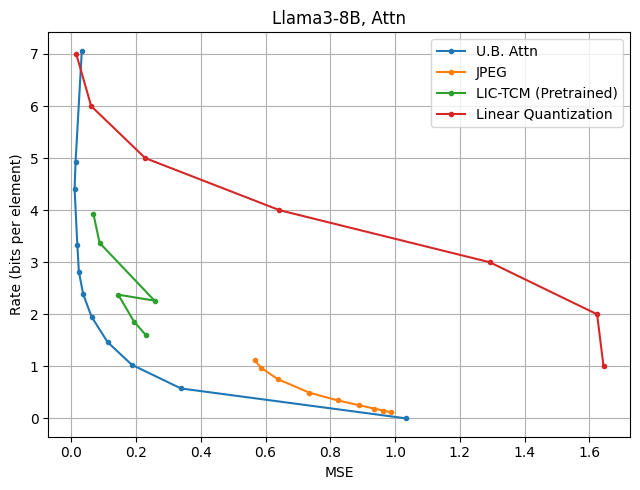

In [60]:
plt.figure(figsize=(6.5, 5))

# plt.subplot(1, 2, 1)
for l, v in plot_data.items():
    if l == 'gaussian': 
        # plt.plot(v['val_mse'], v['val_rate'], marker='o', markersize = 5, linestyle='--', label=l, c= 'r')
        continue
    else:
        plt.plot(v['val_mse'], v['val_rate'], marker='o', markersize = 3, linestyle='-', label=l)
    # plt.plot(v['val_mse'], v['val_rate'], linestyle='-', label=l)

# Training subplot
# # plt.subplot(1, 2, 2)
# for l, v in plot_data.items():
#     if l == 'gaussian': continue
#     plt.plot(v['mse'], v['rate'], marker='o', markersize = 3, linestyle='-', label=l)
    # plt.plot(v['mse'], v['rate'], linestyle='-', label=l)

# Validation subplot 설정
# plt.subplot(1, 2, 1)
quant_bits = [1, 2, 3, 4, 5, 6, 7, 8]
mlp_quant_mse = [1.0000164869236037, 0.9993737145706393, 0.9887189679460173, 0.7952778297410023, 0.37116162976546385, 0.10550744880290548, 0.02616760658136518, 0.006492661767538381]
attn_quant_mse = [1.6436466818640247, 1.6236762742152016, 1.2921279783070763, 0.6426828348204263, 0.22821856959557643, 0.0611583548993061, 0.01520839248038775, 0.003791649803076995]
plt.plot(attn_quant_mse[:7], quant_bits[:7], marker='o', markersize = 3, linestyle='-', label=f'Linear Quantization', alpha = 1)

# plt.scatter(x, y, color = 'red', s = 30, label=f'Linear Quantization')
plt.title('Llama3-8B, Attn')
plt.xlabel('MSE')
plt.ylabel('Rate (bits per element)')
plt.legend()
plt.grid(True)

# # Training subplot 설정
# plt.subplot(1, 2, 2)
# plt.title('Llama3-8B, MLP')
# plt.xlabel('MSE')
# plt.ylabel('Rate (bits per element)')
# plt.legend()
# plt.grid(True)

# 서브플롯 전체 보여주기
plt.tight_layout()
plt.show()